### Import Libraries

In [2]:
import torch
import numpy as np
from LISTA_essential import LISTA_train, LISTA_test
import matplotlib.pyplot as plt
import time
import torch.nn as nn
import utility

### Data Generation

In [5]:
SNR_list = range(5, 55, 5)

seed = 10
print('seed: ', seed)
np_seed = np.random.RandomState(seed)

sparsity = 3        #3
m = 30              #30
n = 100              #100

numTrain = 10000
numTest = 1000

A = generate_measurement_matrix(n, m, np_seed)

datagenerator = utility.datagen(n, m, sparsity, np_seed, A, SNR_list)
X_train, Y_train = datagenerator.data_gen(numTrain)
X_test, Y_test = datagenerator.data_gen(numTest)

seed:  10


### Train

In [6]:
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

learning_rate = 5e-4

numEpochs = 25
numLayers = 15

start = time.time()

SNR = 30

net = LISTA_train(X_train, Y_train[SNR_list.index(SNR)], A, numEpochs, numLayers, device, learning_rate)
print(f'time taken is {time.time() - start}')
print('Learned threshold is ', net.thr.T)

Total dataset size is  10000
DataSet size is:  8000
Training - Epoch: 0, Loss: 0.23886504769325256
Training - Epoch: 1, Loss: 0.11975657194852829
Training - Epoch: 2, Loss: 0.09847835451364517
Training - Epoch: 3, Loss: 0.0843920186161995
Training - Epoch: 4, Loss: 0.07386469095945358
Training - Epoch: 5, Loss: 0.06557387113571167
Training - Epoch: 6, Loss: 0.058808743953704834
Training - Epoch: 7, Loss: 0.053170301020145416
Training - Epoch: 8, Loss: 0.0483800508081913
Training - Epoch: 9, Loss: 0.044249027967453
Training - Epoch: 10, Loss: 0.04065714776515961
Training - Epoch: 11, Loss: 0.03749656304717064
Training - Epoch: 12, Loss: 0.03458246961236
Training - Epoch: 13, Loss: 0.032187849283218384
Training - Epoch: 14, Loss: 0.030186720192432404
Training - Epoch: 15, Loss: 0.028419915586709976
Training - Epoch: 16, Loss: 0.026837997138500214
Training - Epoch: 17, Loss: 0.025397762656211853
Training - Epoch: 18, Loss: 0.0240835752338171
Training - Epoch: 19, Loss: 0.02335986495018005

### Test

In [13]:
SNR_list = range(5, 55, 5)
MSE_list = []
HR_list = []
X_est = []
for i in range(len(SNR_list)):
    x_est = LISTA_test(net, Y_test[i], A, device)
    # mse_ = 10*np.log(np.mean(x_est-X_test)**2)
    loss_function = nn.MSELoss()
    l1=loss_function(torch.tensor(x_est),torch.tensor(X_test))
    l2=loss_function(torch.tensor(X_test),torch.zeros_like(torch.tensor(X_test)))
    dbloss = l1.item()/l2.item()
    mse_ = np.log(dbloss)*10
    hr_list = np.array([np.sum((a != 0) & (np.abs(a - b) <= 0.075)) / np.sum(a != 0) * 100 for a, b in zip(X_test.T, x_est.T)])
    hr_ = np.mean(hr_list)
    MSE_list.append(mse_)
    HR_list.append(hr_)
    X_est.append(x_est)
for i in range(len(SNR_list)):
    if i==0:
        print("SNR: 0{} | MSE: {:.2f}dB | Hit Rate: {:.2f}%".format(SNR_list[i], MSE_list[i], HR_list[i]))
        continue
    print("SNR: {} | MSE: {:.2f}dB | Hit Rate: {:.2f}%".format(SNR_list[i], MSE_list[i], HR_list[i]))

SNR: 05 | MSE: 12.16dB | Hit Rate: 14.07%
SNR: 10 | MSE: -18.60dB | Hit Rate: 43.07%
SNR: 15 | MSE: -38.90dB | Hit Rate: 51.57%
SNR: 20 | MSE: -59.43dB | Hit Rate: 90.77%
SNR: 25 | MSE: -67.39dB | Hit Rate: 96.00%
SNR: 30 | MSE: -70.16dB | Hit Rate: 100.00%
SNR: 35 | MSE: -70.65dB | Hit Rate: 100.00%
SNR: 40 | MSE: -72.34dB | Hit Rate: 100.00%
SNR: 45 | MSE: -72.30dB | Hit Rate: 100.00%
SNR: 50 | MSE: -72.60dB | Hit Rate: 100.00%


#### HR, MSE vs SNR

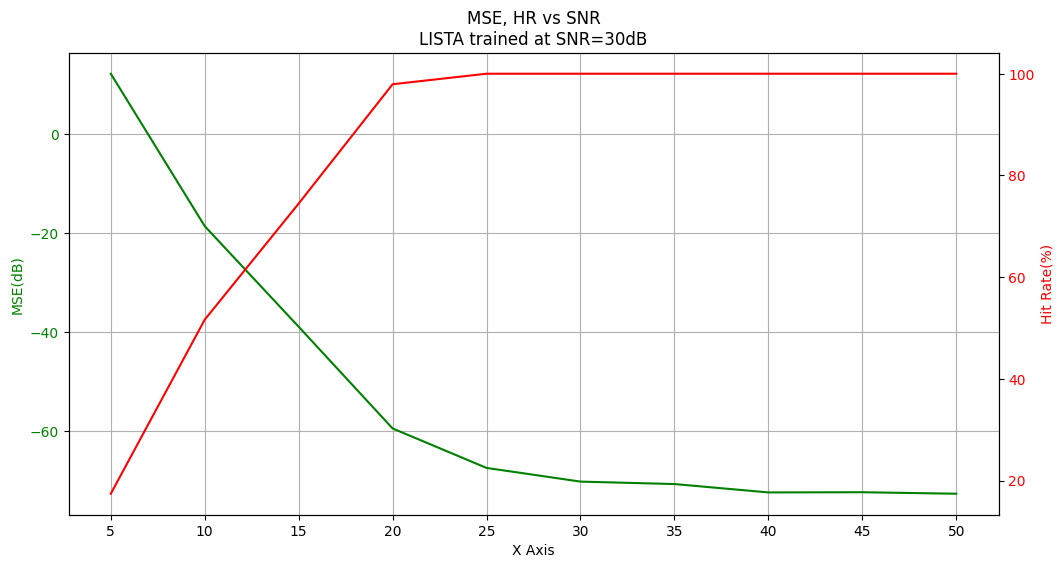

In [11]:
plotter = utility.plotter()
plotter.hr_mse_vs_sigma(SNR_list, MSE_list, HR_list, SNR)

#### Recovery Plots

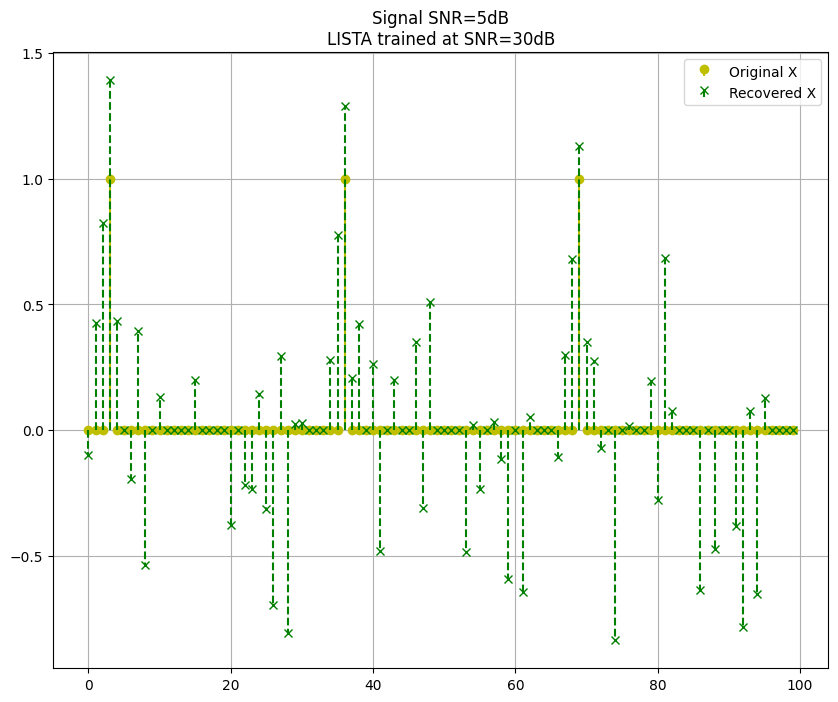

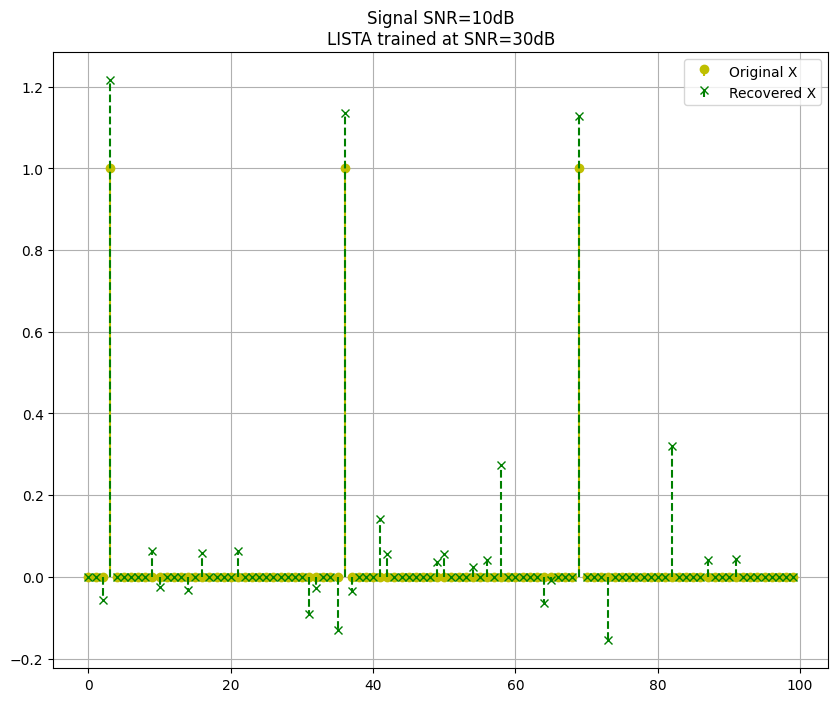

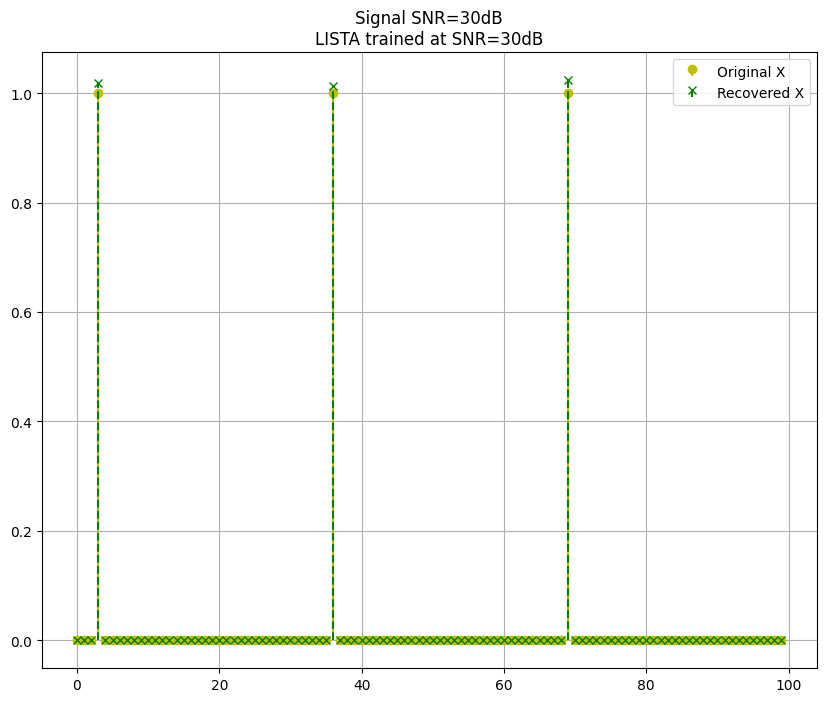

In [15]:
plotter.stem_plot(X_test, X_est, SNR_list,  5, SNR, 10)
plotter.stem_plot(X_test, X_est, SNR_list, 10, SNR, 10)
plotter.stem_plot(X_test, X_est, SNR_list, 30, SNR, 10)